In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

In [51]:
# Para la compatibilidad de GPU y tensorflow uso
# tensorflow==2.10.1
# cuda = 11.2
# cudnn = 8.1.1
# python = 3.10.9
# https://www.tensorflow.org/install/source_windows?#gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("GPUs Available: ", gpus)
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
      print(e)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Especificación de cada ruta

In [52]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
labels = 'model/keypoint_classifier/keypoint_classifier_label.csv'

# Configuración del número de clasificaciones

In [53]:
# Leer el contenido del archivo, eliminando el BOM si está presente
with open(labels, 'r', encoding='utf-8-sig') as f:
    content = f.read().splitlines()

# Convertir el contenido a un array de NumPy
labels_name = np.array(content, dtype=str)

print(labels_name)
NUM_CLASSES = len(labels_name)

['Open' 'Close' 'Pointer' 'Mouse_static' 'Mouse_click_right']


# Carga de datos de entrenamiento

In [54]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [55]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Construcción del modelo

In [57]:
from keras.regularizers import l2
model = keras.models.Sequential([
    keras.layers.Input((21 * 2, )),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [58]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2752      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 5)                

In [59]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [60]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [61]:
# Entrenar el modelo y guardar la historia
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
20/28 [====================>.........] - ETA: 0s - loss: 1.6895 - accuracy: 0.2561
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
28/28 [==============================] - 1s 13ms/step - loss: 1.6718 - accuracy: 0.2817 - val_loss: 1.5653 - val_accuracy: 0.4138
Epoch 2/1000
23/28 [=======================>......] - ETA: 0s - loss: 1.5583 - accuracy: 0.3862
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
28/28 [==============================] - 0s 8ms/step - loss: 1.5481 - accuracy: 0.3927 - val_loss: 1.3813 - val_accuracy: 0.5952
Epoch 3/1000
20/28 [====================>.........] - ETA: 0s - loss: 1.4310 - accuracy: 0.4607
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
28/28 [==============================] - 0s 11ms/step - loss: 1.4187 - accuracy: 0.4643 - val_loss: 1.1743 - val_accuracy: 0.5896
Epoch 4/1000
25/28 [=========================>....] - ETA: 0s - loss: 1.2926 - accuracy: 0.5

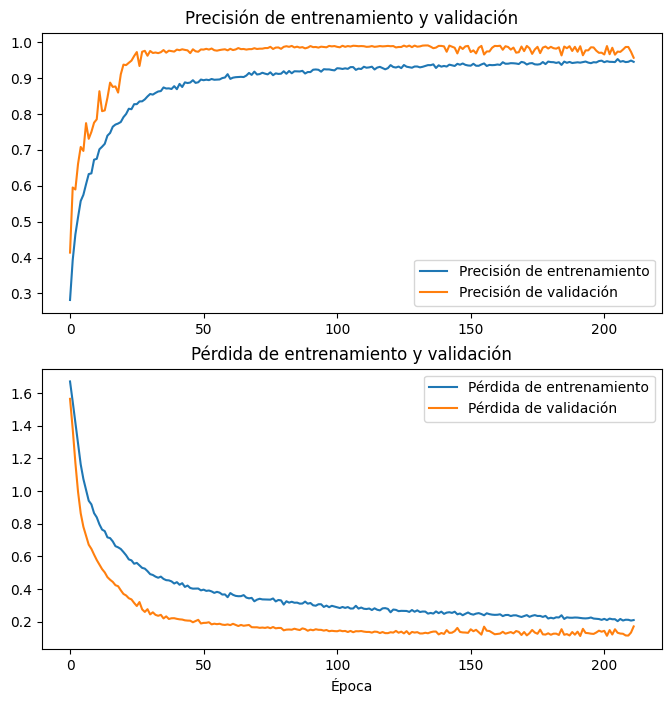

In [62]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [66]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 [==============================] - 0s 5ms/step - loss: 0.1717 - accuracy: 0.9568


In [67]:
# Carga del modelo guardado
model = tf.keras.models.load_model(model_save_path)

In [68]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 50ms/step
[2.2787151e-04 1.8790967e-04 2.0341745e-04 1.2695607e-02 9.8668516e-01]
4


# Matriz de confusión

74/74 [==============================] - 0s 3ms/step


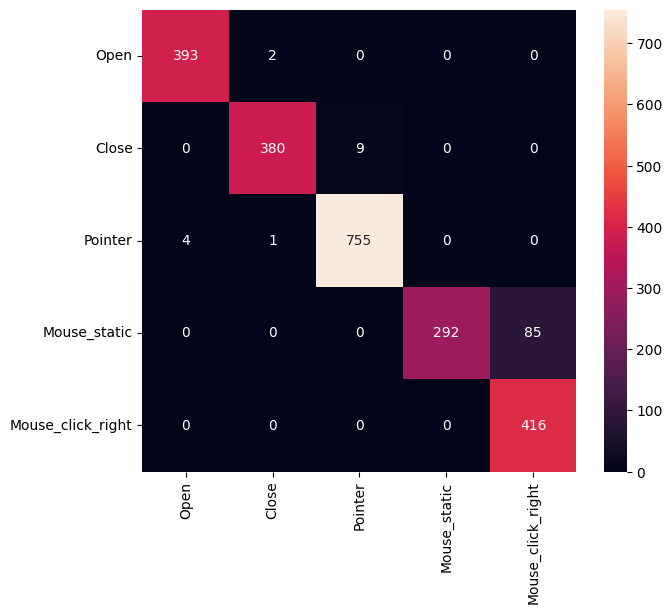

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       395
           1       0.99      0.98      0.98       389
           2       0.99      0.99      0.99       760
           3       1.00      0.77      0.87       377
           4       0.83      1.00      0.91       416

    accuracy                           0.96      2337
   macro avg       0.96      0.95      0.95      2337
weighted avg       0.96      0.96      0.96      2337



In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, labels_name, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=range(len(labels_name)))
    
    df_cmx = pd.DataFrame(cmx_data, index=labels_name, columns=labels_name)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred, labels_name)

# Conversión a modelo para Tensorflow-Lite

In [70]:
# Guardar como modelo exclusivamente para inferencia
model.save(model_save_path, include_optimizer=False)

In [71]:
# Modelo de conversión (cuantificación)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmpv4x3ny3y\assets


INFO:tensorflow:Assets written to: C:\Users\GAMA\AppData\Local\Temp\tmpv4x3ny3y\assets


10240

# Prueba de inferencia

In [72]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [73]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [74]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [76]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2848655e-04 1.8399849e-04 1.9557418e-04 1.2775978e-02 9.8661590e-01]
4
